# Image data Preprocessing

## Importing

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import time

sns.set()

### importing text data 

In [5]:
df_X = pd.read_csv('./datasets/X_train_update.csv', index_col = 0)

print("nb_entries, nb_columns = ", df_X.shape)
display(df_X.head())

nb_entries, nb_columns =  (84916, 4)


,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


### Target variable

In [6]:
df_y = pd.read_csv('./datasets/Y_train_CVw08PX.csv', index_col = 0)

print(print("nb_entries, nb_columns = ", df_y.shape))
display(df_y.head())

nb_entries, nb_columns =  (84916, 1)
None


,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705


### Merged dataset

In [7]:
df = pd.concat([df_y,df_X], axis = 1)

## Rename the variable 'designation' by 'title' which is more convenient
df.rename({'designation':'title'}, axis = 1, inplace = True)

df.head()

,prdtypecode,title,description,productid,imageid
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,2705,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


### Product Class dataframe 

In [8]:
product_class = pd.read_csv('./datasets/product_class.csv', sep = ';')
product_class.drop('target', axis = 1, inplace = True) 
display(product_class)

,prdtypecode,prodtype
0,10,livres_adulte
1,40,jeux_videos_import
2,50,accessoires_jeux_videos
3,60,jeux_et_consoles_retro
4,1140,goodies_geek
5,1160,cartes_a_jouer
6,1180,figurines_wargames
7,1280,jouets_enfance
8,1281,jeux_societe
9,1300,modeles_reduits_ou_telecommandes


# Image Data Exploration

### Fetching and plotting a single image of the object at row idx

./datasets/image_train/image_1158032634_product_2694028060.jpg


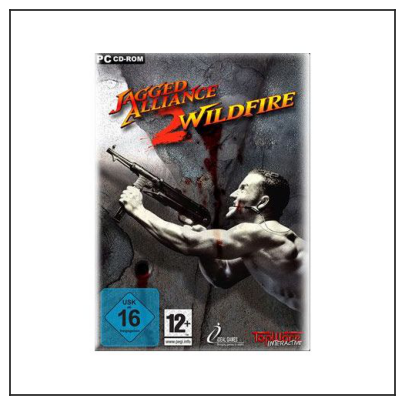

In [9]:
idx = 745

## load image 
file = "./datasets/image_train/image_"+str(df.loc[idx,'imageid'])+"_product_"+str(df.loc[idx,'productid'])+".jpg"
image = cv2.imread(file)
print(file)

sns.set_style("white")
_, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(image[:,:,::-1])
ax.grid(False)
ax.set_xticks([]);ax.set_yticks([])
sns.set()


## Reduce white background on images (crop & resize)

### display single image from one category

Select one category and display the df index of product belonging to that cathegory.  
The catageory with a lot of background padding are the ones ot prdtypecode = 1300.  

In [10]:
codetype = product_class[product_class['prodtype'] == 'modeles_reduits_ou_telecommandes']['prdtypecode'].values[0]
codetype #= 2905

1300

In [11]:
print("These are some products of the category 'modeles_reduits_ou_telecomandes':")
df[ df['prdtypecode'] == codetype].index.values[:10]

These are some products of the category 'modeles_reduits_ou_telecomandes':


array([ 24,  59,  63,  81, 104, 105, 134, 140, 146, 153], dtype=int64)

I try to identify the coordinates (pixel_x, pixel_y) of a point right at the edge of the object and the white background.  
This allows to stablish that 'white' padding background is tipiccally represented by RGB > 430 approx.  
This will be used as a threshold for croping the image to improve information density.

./datasets/image_train/image_1260268384_product_3893192098.jpg


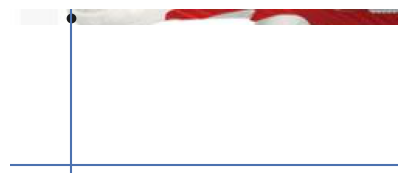

In [12]:
## verify image for single cases:
idx = 59

## load image 
file = "./datasets/image_train/image_"+str(df.loc[idx,'imageid'])+"_product_"+str(df.loc[idx,'productid'])+".jpg"
image = np.int64(cv2.imread(file))
print(file)

#sns.set_style("white")
fig, ax = plt.subplots(1,1, figsize=(5,5))

#ax.imshow(image[:,:,::-1])         # full image

# chunk of the image: [row_range, col_range, ch_range] 
col_min = 0
col_max = 250
row_min = 160
row_max = 170
ax.imshow(image[ row_min:row_max, col_min:col_max, ::-1]) 

# plot single point, coordinates are with respect to the coordinates of the top left corner of the displayed image range.
ax.plot(39,5,marker = 'o', color = 'k')

ax.axhline(y = 100)  # Nb of pixel (rows or cols) below the corner coordinate (relative coords)
ax.axvline(x = 39)

ax.grid(False)
ax.axis('off');
sns.set()


In [13]:
# pixel values along a horizontal line at level y=100 from x=0 to x=px_max for one channel. 
row_fix = 165
print(image[ row_fix, :col_max, 1])  

[254 255 255 253 253 255 252 247 247 247 247 247 247 247 247 247 247 247
 247 247 247 247 247 247 248 246 246 248 248 246 248 253 250 255 255 250
 253 255 250 231 215 211 211 213 215 214 213 214 213 215 217 218 218 219
 220 221 218 218 216 215 217 222 224 223 227 227 227 227 228 229 230 230
 227 227 226 225 224 224 225 226 227 227 226 226 227 227 228 229 227 228
 229 231 232 232 232 232 240 222 233 187  76  39  56  41  54  54  52  49
  43  36  28  24  15  19  25  32  40  48  53  57  49  42  36  39  47  61
  78  92 166 176 190 195 192 188 188 190 193 196 199 201 202 204 207 209
 207 206 206 204 205 205 206 206 181 192 167 100  45  28  30  29  34  34
  35  42  60  93 132 162 177 191 207 217 222 224 226 229 220 220 221 221
 222 221 219 217 219 220 210 181 133  82  50  40  34  33  30  28  26  24
  24  24  26  26  27  26  27  28  28  29  34  32  27  22  17  16  19  23
  26  25  22  20  17  15  14  13  23  18  24  31  23  19  19  17  13  26
  28  27  32  29  18  13  14  15  20  26  27  25  2

### Define crop images functions

In [45]:

def find_left_boundary(image_array, threshold):
    height, width, _ = image_array.shape

    left_boundary = None
    for col in range(width):
        
        if np.any(image_array[:,col,:] < threshold):
            left_boundary = col
            break

    if left_boundary is None:
        left_boundary = 0

    return left_boundary

def find_right_boundary(image_array, threshold):
    height, width, _ = image_array.shape

    right_boundary = None
    for col in range(width - 1, -1, -1):
        
        if np.any(image_array[:,col,:] < threshold):
            right_boundary = col
            break

    if right_boundary is None:
        right_boundary = width - 1

    return right_boundary

def find_top_boundary(image_array, threshold):
    height, width, _ = image_array.shape

    top_boundary = None
    for row in range(height):
    
        if np.any(image_array[row,:,:] < threshold):
            top_boundary = row
            break

    if top_boundary is None:
        top_boundary = 0

    return top_boundary

def find_bottom_boundary(image_array, threshold):
    height, width, _ = image_array.shape

    bottom_boundary = None
    for row in range(height - 1, -1, -1):
        
        if np.any(image_array[row,:,:] < threshold):
            bottom_boundary = row
            break

    if bottom_boundary is None:
        bottom_boundary = height - 1

    return bottom_boundary



def crop_square(image_array, left, right, top, bottom):
    cropped_width = right - left + 1
    cropped_height = bottom - top + 1

    # Calculate the side length of the largest square that fits all boundaries
    side_length = max(cropped_width, cropped_height)

    horizontal_pad = (side_length - cropped_width) // 2
    vertical_pad = (side_length - cropped_height) // 2

    left_new = max(0, left - horizontal_pad)
    right_new = min(image_array.shape[1] - 1, right + horizontal_pad)
    top_new = max(0, top - vertical_pad)
    bottom_new = min(image_array.shape[0] - 1, bottom + vertical_pad)
    
    
    ## verify if vertical dimension iqueals horizontal dimension, and correct:
    if (right_new - left_new) > (bottom_new - top_new):
        if top_new > 0:
            top_new = top - vertical_pad - 1
        elif bottom_new < image_array.shape[0] - 1:
            bottom_new = bottom + vertical_pad + 1
    elif (right_new - left_new) < (bottom_new - top_new):
        if left_new > 0:
            left_new = left - horizontal_pad - 1
        elif right_new < image_array.shape[1] - 1:
            right_new = right + horizontal_pad + 1
    

    cropped_image = image_array[top_new : bottom_new+1, left_new : right_new+1, :]
    return cropped_image

**chose an image from the problematic category**

In [46]:
## verify with one example image: someexamples are idx = 63, 11, 12, 1231, 104 (it shouldn't crop), 153, 84830 (not centered)
## others 17798, 55798

idx = 84

## load image 
file = "./datasets/image_train/image_"+str(df.loc[idx,'imageid'])+"_product_"+str(df.loc[idx,'productid'])+".jpg"
image = cv2.imread(file)

#print(file)
print(cv2.imread(file).shape)
print(type(cv2.imread(file)))
print(type(np.int64(cv2.imread(file))))

(500, 500, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


**find new boundaries given a threshold RGB intensity. Then plot before / after cropping**  


In [47]:
#image = test_matrix
threshold = 230

# Calculate the boundaries (assuming you have the threshold defined)
left_boundary = find_left_boundary(image, threshold)
right_boundary = find_right_boundary(image, threshold)
top_boundary = find_top_boundary(image, threshold)
bottom_boundary = find_bottom_boundary(image, threshold)

print("Left Boundary:", left_boundary)
print("Right Boundary:", right_boundary)
print("top Boundary:", top_boundary)
print("bottom Boundary:", bottom_boundary)


# Crop the image using the calculated boundaries
cropped_image = crop_square(image, left_boundary, right_boundary, top_boundary, bottom_boundary)

Left Boundary: 109
Right Boundary: 389
top Boundary: 144
bottom Boundary: 354


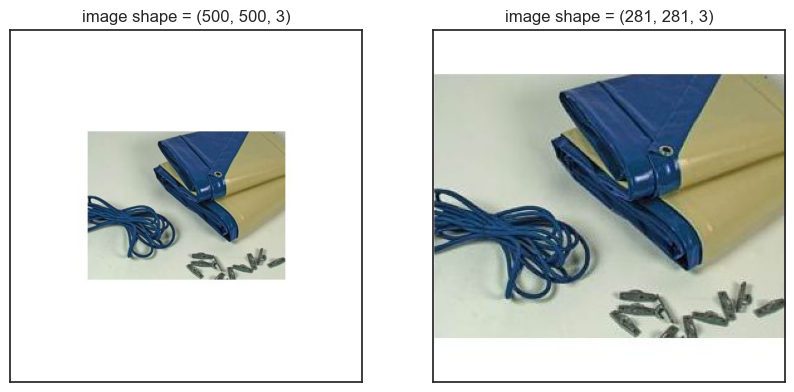

In [48]:
sns.set_style("white")
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(image[:,:,::-1])
axs[1].imshow(cropped_image[:,:,::-1])

axs[0].set_title("image shape = " + str(image.shape))
axs[1].set_title("image shape = " + str(cropped_image.shape))

for ax in axs:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
sns.set()


### resize cropped image (downscale)

In [49]:
## define the final number of pixels per side:
Nb_px = 100
resized_image = cv2.resize(cropped_image, (Nb_px, Nb_px)) 


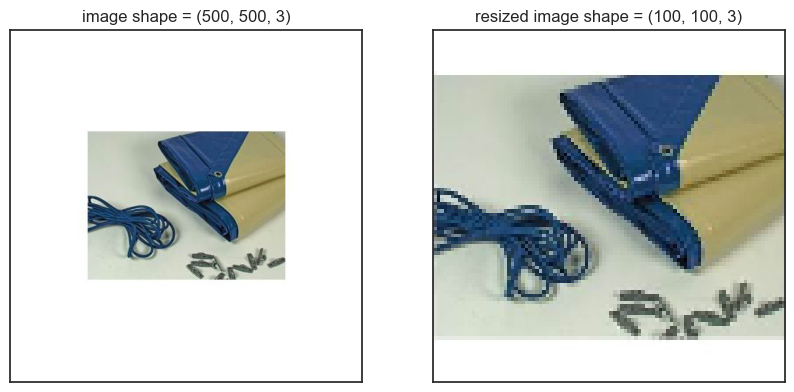

In [50]:
sns.set_style("white")
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(image[:,:,::-1])
axs[1].imshow(resized_image[:,:,::-1])

axs[0].set_title("image shape = " + str(image.shape))
axs[1].set_title("resized image shape = " + str(resized_image.shape))

for ax in axs:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
sns.set()


In [51]:
## check some values:
print("some RGB values \n-----------------------------")
print(cropped_image[:10,0,0])
print(resized_image[:10,0,0], '\n')

print("image sizes \n-----------------------------")
print("original =", image.shape)
print("cropped =", cropped_image.shape)
print("resized =", resized_image.shape)

some RGB values 
-----------------------------
[255 255 255 255 255 255 255 255 255 255]
[255 255 255 255 255 255 255 255 255 255] 

image sizes 
-----------------------------
original = (500, 500, 3)
cropped = (281, 281, 3)
resized = (100, 100, 3)


### vectorize image
Image should be represented in a flattened string
[ ] should i keep the 3 channels or average them ? averaging will reduce size of vector by 3.

In [52]:
resized_image.shape

(100, 100, 3)

In [53]:
Nx, Ny, Nch = resized_image.shape
vector_image = resized_image.reshape(Nx*Ny*Nch)
print(vector_image.shape)

(30000,)


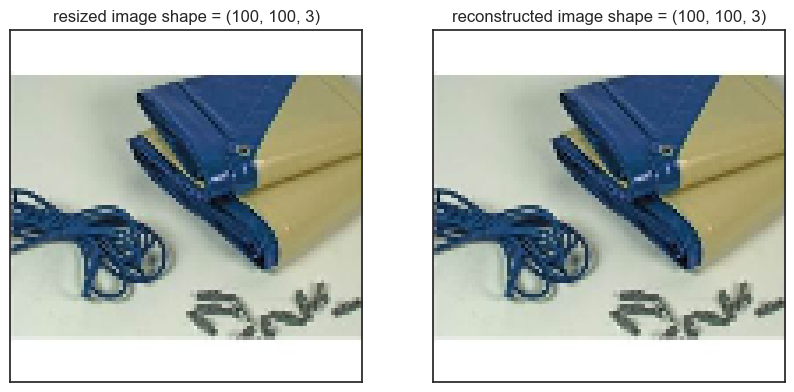

In [54]:
## test recovery
reconstructed_image = vector_image.reshape(Nx,Ny,Nch)

sns.set_style("white")
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(resized_image[:,:,::-1])
axs[1].imshow(reconstructed_image[:,:,::-1])

axs[0].set_title("resized image shape = " + str(resized_image.shape))
axs[1].set_title("reconstructed image shape = " + str(reconstructed_image.shape))

for ax in axs:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
sns.set()


## implementation in the whole dataframe
* cropping white background
* resizing images
* vectorizing images

* save vector(size = N) into a dataframe with N columns (pixels)


In [55]:
def crop_image(image, threshold):

    # Calculate the boundaries at which the RGB threshold is touched
    left_boundary = find_left_boundary(image, threshold)
    right_boundary = find_right_boundary(image, threshold)
    top_boundary = find_top_boundary(image, threshold)
    bottom_boundary = find_bottom_boundary(image, threshold)

    # crop image smallest square possible (including all boundaries inside)
    cropped_image = crop_square(image, left_boundary, right_boundary, top_boundary, bottom_boundary)

    return cropped_image


def image_vectorization(df, threshold, new_pixel_nb, verbose = True):
    t0 = time.time()
    
    img_array = np.empty((df.shape[0], new_pixel_nb * new_pixel_nb * 3), dtype = np.uint8)
    
    for idx in range(df.shape[0]):
        
        # load image
        file = "./datasets/image_train/image_"+str(df.loc[idx,'imageid'])+"_product_"+str(df.loc[idx,'productid'])+".jpg"
        image = cv2.imread(file)
        
        # crop image 
        cropped_image = crop_image(image, threshold = threshold)
        
        # resize image (downscale)
        resized_image = cv2.resize(cropped_image, (new_pixel_nb, new_pixel_nb))
    
        # vectorize image (3D -> 1D) and append to general array
        img_array[idx,...] = resized_image.reshape(new_pixel_nb*new_pixel_nb*3)
        
        if verbose:
            checkpoints = [1000,2000,3000,4000]
            if ((idx in checkpoints) or idx%5000 ==0):
                print("%d images at time %0.2f minutes" %(idx, ((time.time()-t0)/60) ) )

    ## prepare dataframe with vector images
    df_vectors = pd.DataFrame(data = img_array) #default col_names

    df_image_ids = df[['prdtypecode', 'productid', 'imageid']]
    
    df_image_vectors = pd.concat([df_image_ids, df_vectors], axis = 1)
    
    t1 = time.time()
    if verbose:
        #print("Vectorization of %d images takes %0.2f seconds" %(df.shape[0],(t1-t0)) )
        print("Vectorization of %d images takes %0.2f minutes" %(df.shape[0],((t1-t0)/60)) )                
    
    return df_image_vectors


### Test: vectorize a small dataset

In [58]:
df_2 = df.loc[:1000,:]
df_2.head()

,prdtypecode,title,description,productid,imageid
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,2705,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


In [59]:
df2_vec_images = image_vectorization(df_2, threshold = 230, new_pixel_nb = 100, verbose = True)
df2_vec_images.head()

0 images at time 0.00 minutes
1000 images at time 0.12 minutes
Vectorization of 1001 images takes 0.12 minutes


,prdtypecode,productid,imageid,0,1,2,3,4,5,6,...,29990,29991,29992,29993,29994,29995,29996,29997,29998,29999
0,10,3804725264,1263597046,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,2280,436067568,1008141237,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,50,201115110,938777978,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,1280,50418756,457047496,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,2705,278535884,1077757786,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


### Vectorize all dataset

[x] Using image_vectorization_v2 instead of image_vectorization reduces the time by half (to 53 % of previous value)  
[x] Estimeted total time of image vectorization is 5.38 hs (instead of 10.15 hs before)
[x] remove resize_image call reduces estimated time by 1min per 3000 images (estimated total time 5hs)
[x] improved functions to find boundaries and to crop by removing unnecessary operations

**important:** The following cell takes 12 minutes.  
<span style='color: #000000; background-color: #f1c232;'>
Do not run, but instead load the previous calculations
</span>
(See section below)

<!--font-family: monospace; -- >

In [60]:
recalculate_vectorization = True

if recalculate_vectorization:
    df_vectorized_images = image_vectorization(df, threshold = 230, new_pixel_nb = 200, verbose = True)
    

0 images at time 0.00 minutes
1000 images at time 0.09 minutes
2000 images at time 0.22 minutes
3000 images at time 0.35 minutes
4000 images at time 0.47 minutes
5000 images at time 0.60 minutes
10000 images at time 1.22 minutes
15000 images at time 1.85 minutes
20000 images at time 2.47 minutes
25000 images at time 3.07 minutes
30000 images at time 3.69 minutes
35000 images at time 4.31 minutes
40000 images at time 4.91 minutes
45000 images at time 5.53 minutes
50000 images at time 6.15 minutes
55000 images at time 6.75 minutes
60000 images at time 7.36 minutes
65000 images at time 7.98 minutes
70000 images at time 8.58 minutes
75000 images at time 9.23 minutes
80000 images at time 9.86 minutes
Vectorization of 84916 images takes 29.21 minutes


In [61]:
## verify data types
df_vectorized_images.iloc[:,:6].dtypes
#type(df_image_vectors.iloc[0,0].values)

prdtypecode    int64
productid      int64
imageid        int64
0              uint8
1              uint8
2              uint8
dtype: object

### Dump vectorized dataframe into a local file

In [62]:
from datetime import date, datetime

def date_time():
    today = date.today()
    now = datetime.now()
    
    return today.strftime("_%Y%m%d") + "_" + now.strftime("%H%M")

In [63]:
write_pickle = True

time_stamp = date_time()
t0 = time.time()
if write_pickle:
    filename = 'df_vectorized_images_200px' + time_stamp + '.pkl'
    df_vectorized_images.to_pickle(filename) #, header=True, index=False

print("Total time = %0.2f seconds" %(time.time()-t0) )    
write_pickle = False

Total time = 84.07 seconds


### Load vectorized dataset

In [64]:
### test recover df from pickle
read_pickle = True
filename = 'df_vectorized_images_200px' + time_stamp + '.pkl'

t0 = time.time()
if read_pickle:
    df_vectorized_images = pd.read_pickle(filename)

    display(df_vectorized_images.head())
    print(df_vectorized_images.shape)

print("Total time to read = %0.2f seconds" %(time.time()-t0))    

,prdtypecode,productid,imageid,0,1,2,3,4,5,6,...,119990,119991,119992,119993,119994,119995,119996,119997,119998,119999
0,10,3804725264,1263597046,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,2280,436067568,1008141237,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,50,201115110,938777978,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,1280,50418756,457047496,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,2705,278535884,1077757786,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


(84916, 120003)
Total time to read = 48.69 seconds


3
(84916, 120003)
<class 'numpy.ndarray'>
(200, 200, 3)


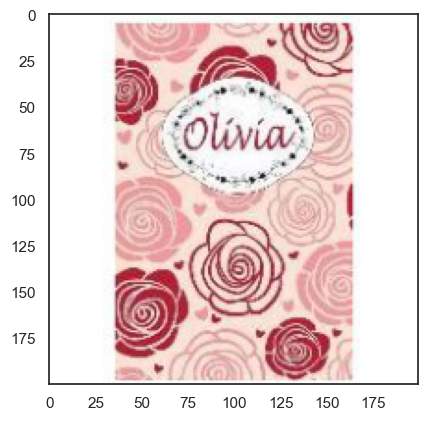

In [67]:
## verify dtypes and shape of recovered dataset
print(sum(df_vectorized_images.dtypes != 'uint8'))
print(df_vectorized_images.shape)

## recover a single image:
img = df_vectorized_images.iloc[0,3:].to_numpy(copy = True)
#img = np.array(img)
img = img.reshape((200,200,3))

print(type(img))
print(img.shape)

## print recovered image
sns.set_style('white')
plt.imshow(img[:,:,::-1])  # channels need to be inverted to get the roght color
for ax in axs:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
sns.set()


## Get Average RGB intensity for every Image
**important:** The following cell takes >5 (<10) minutes.  
<span style='color: #000000; font-family: monospace; background-color: #f1c232;'>
Do not run, but instead load the previously calculation
</span>
(See section below)

In [100]:
def get_image_mean_RGB(df, image_type, Nb_pixels, verbose = True):
    '''
    takes a df with the vectorized images and get the mean R, G, B for each image.
    image_type = 'cropped_image' to indicate if images are reconstructed from the df or
    if they are fetched directly from the image folder (image_type = 'raw_image')
    '''
    t0 = time.time()
    checkpoints = [1000,2000,3000,4000]
    
    image_meanRGBs = np.empty((df.shape[0], 3)) 
    idx = 0

    # fetch raw image
    if image_type == 'raw':
        for idx in range(df.shape[0]):
            file = "./datasets/image_train/image_"+str(df.loc[idx,'imageid'])+"_product_"+str(df.loc[idx,'productid'])+".jpg"
            image = cv2.imread(file)        

            image_meanRGBs[idx, : ] = [ image[:,:,channel].mean() for channel in range(3) ]

            if verbose:
                if ((idx in checkpoints) or (idx%5000 == 0)):
                    print("%d images at time %0.2f minutes" %(idx, ((time.time()-t0)/60) ) )
    
    
    # reconstruc cropped image from passed datafrae
    if image_type == 'cropped':
        for idx in range(df.shape[0]):
            image = df.iloc[idx, 3:]#.to_numpy(copy = True)
            image = np.array(image).reshape(Nb_pixels, Nb_pixels, 3)

            image_meanRGBs[idx, : ] = [ image[:,:,channel].mean() for channel in range(3) ]

            if verbose:
                if ((idx in checkpoints) or (idx%5000 == 0)):
                    print("%d images at time %0.2f minutes" %(idx, ((time.time()-t0)/60) ) )

        
    t1 = time.time()
    if verbose:
        print("Getting mean RGB for %d images takes %0.2f minutes"%(df.shape[0],((t1-t0)/60)) )

    return image_meanRGBs


In [78]:
recalculate_meanRGBs = False #True

if recalculate_meanRGBs:
    meanRGBs = get_image_mean_RGB(df_vectorized_images, image_type='cropped', 100)


0 images at time 0.00 minutes
1000 images at time 0.27 minutes
2000 images at time 0.55 minutes
3000 images at time 0.82 minutes
4000 images at time 1.11 minutes
5000 images at time 1.38 minutes
10000 images at time 2.74 minutes
15000 images at time 4.13 minutes
20000 images at time 5.78 minutes
25000 images at time 7.14 minutes
30000 images at time 8.51 minutes
35000 images at time 9.86 minutes
40000 images at time 11.21 minutes
45000 images at time 12.64 minutes
50000 images at time 14.00 minutes
55000 images at time 15.35 minutes
60000 images at time 16.70 minutes
65000 images at time 18.05 minutes
70000 images at time 19.39 minutes
75000 images at time 20.77 minutes
80000 images at time 22.12 minutes
Getting mean RGB for 84916 images takes 23.44 minutes


**fetching images is faster (but his are not the cropped images!!)**  
0 images at time 0.00 minutes  
1000 images at time 0.10 minutes  
5000 images at time 0.48 minutes  
10000 images at time 0.97 minutes  
80000 images at time 7.51 minutes  
Getting mean RGB for 84916 images takes 7.97 minutes  

**reconstructing cropped images takes:**  
1000 images at time 0.26 minutes  
5000 images at time 1.32 minutes  
10000 images at time 2.65 minutes  
80000 images at time 21.68 minutes  
Getting mean RGB for 84916 images takes 23.04 minutes  

In [86]:
print(meanRGBs.shape)

## add values into dataframe columns
# df_vectorized_images.insert(loc=3, column='meanR', value=meanRGBs[:,0])
# df_vectorized_images.insert(loc=4, column='meanG', value=meanRGBs[:,1])
# df_vectorized_images.insert(loc=5, column='meanB', value=meanRGBs[:,2])

df_vectorized_images.head()

(84916, 3)


,prdtypecode,productid,imageid,meanR,meanG,meanB,px_0,px_1,px_2,px_3,...,px_29990,px_29991,px_29992,px_29993,px_29994,px_29995,px_29996,px_29997,px_29998,px_29999
0,10,3804725264,1263597046,205.4529,206.5443,234.1815,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,2280,436067568,1008141237,167.7998,172.5678,176.3561,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,50,201115110,938777978,251.9491,248.2853,244.1458,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,1280,50418756,457047496,76.9653,82.1617,111.9041,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,2705,278535884,1077757786,209.4138,198.2848,174.6685,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [87]:
df_vectorized_images.columns[:6].to_list()

['prdtypecode', 'productid', 'imageid', 'meanR', 'meanG', 'meanB']

In [81]:
column_names = df_vectorized_images.columns[:6].to_list()

Nb_pixel = 100
for i in range(Nb_pixel*Nb_pixel*3):
    column_names.append('px_'+str(i))
    
print(column_names[:10])
print(column_names[-10:])

['prdtypecode', 'productid', 'imageid', 'meanR', 'meanG', 'meanB', 'px_0', 'px_1', 'px_2', 'px_3']
['px_29990', 'px_29991', 'px_29992', 'px_29993', 'px_29994', 'px_29995', 'px_29996', 'px_29997', 'px_29998', 'px_29999']


In [82]:
df_vectorized_images.columns = column_names
df_vectorized_images.head()

,prdtypecode,productid,imageid,meanR,meanG,meanB,px_0,px_1,px_2,px_3,...,px_29990,px_29991,px_29992,px_29993,px_29994,px_29995,px_29996,px_29997,px_29998,px_29999
0,10,3804725264,1263597046,205.4529,206.5443,234.1815,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,2280,436067568,1008141237,167.7998,172.5678,176.3561,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,50,201115110,938777978,251.9491,248.2853,244.1458,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,1280,50418756,457047496,76.9653,82.1617,111.9041,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,2705,278535884,1077757786,209.4138,198.2848,174.6685,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


### Dump Computed dataframe containing mean_RGBs

In [83]:
write_df_meanRGBS = True

t0 = time.time()

if write_df_meanRGBS:
    filename = 'df_vectorized_images_meanRGBs' + '.pkl'
    df_vectorized_images.to_pickle(filename) #, header=True, index=False

print("Total time = %0.2f seconds" %(time.time()-t0) )    


Total time = 9.85 seconds


### Load Preprocessed image dataframe

In [101]:
### test recover df from pickle
read_df_meanRGBs = True
filename = 'df_vectorized_images_meanRGBs' + '.pkl'

t0 = time.time()

if read_df_meanRGBs:
    df_images = pd.read_pickle(filename)

    display(df_images.head())
    print(df_images.shape)

print("Total time to read = %0.2f seconds" %(time.time()-t0))    

,prdtypecode,productid,imageid,meanR,meanG,meanB,px_0,px_1,px_2,px_3,...,px_29990,px_29991,px_29992,px_29993,px_29994,px_29995,px_29996,px_29997,px_29998,px_29999
0,10,3804725264,1263597046,205.4529,206.5443,234.1815,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,2280,436067568,1008141237,167.7998,172.5678,176.3561,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,50,201115110,938777978,251.9491,248.2853,244.1458,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,1280,50418756,457047496,76.9653,82.1617,111.9041,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,2705,278535884,1077757786,209.4138,198.2848,174.6685,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


(84916, 30006)
Total time to read = 3.24 seconds


### Color Distributions:   
distribution of $\overline{R}_{img}$, $\overline{G}_{img}$ and $\overline{B}_{img}$ in the whole dataset all mixed.

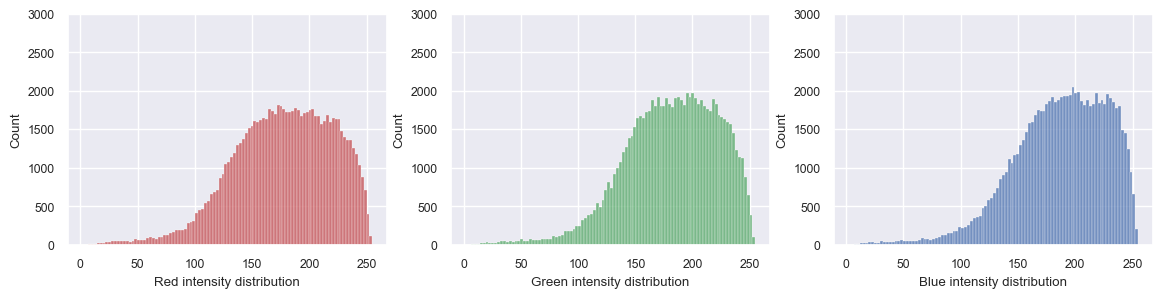

In [222]:
sns.set(font_scale = 0.8)
ylim = 3000

fig, axs = plt.subplots(1,3,figsize=(14,3) )
#fig.suptitle("Average image RGB intensities distributions")

sns.histplot(df_images.meanR, bins = 100, ax = axs[0], color = 'r').set(ylim=(0, ylim))
axs[0].set_xlabel("Red intensity distribution")
sns.histplot(df_images.meanG, bins = 100, ax = axs[1], color = 'g').set(ylim=(0, ylim))#, yticklabels=[], ylabel=None
axs[1].set_xlabel("Green intensity distribution")
sns.histplot(df_images.meanB, bins = 100, ax = axs[2], color = 'b').set(ylim=(0, ylim))
axs[2].set_xlabel("Blue intensity distribution")
#axs[0].set_title("Average image Red intensity distribution")
sns.set()


### Mean RGB intensity per category
* repressentative average channel value per category (mean of means): $\overline{R}_{cat}$, $\overline{G}_{cat}$ and $\overline{B}_{cat}$

In [217]:
RGB_per_cat = df_images[['prdtypecode','meanR','meanG','meanB']].groupby('prdtypecode')['meanR','meanG','meanB'].mean()

RGB_per_cat.head()

C:\Users\19rod\AppData\Local\Temp\ipykernel_13516\2902228034.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  RGB_per_cat = df_images[['prdtypecode','meanR','meanG','meanB']].groupby('prdtypecode')['meanR','meanG','meanB'].mean()


,meanR,meanG,meanB
prdtypecode,,,
10,164.672125,173.900505,181.811280
40,154.848153,160.053910,167.365718
50,179.171735,180.284372,183.397090
60,173.713197,174.356024,178.503859
1140,171.882739,176.053288,183.304761


<ins>**Visualisation**</ins>

In [218]:
# help(adjust_text)

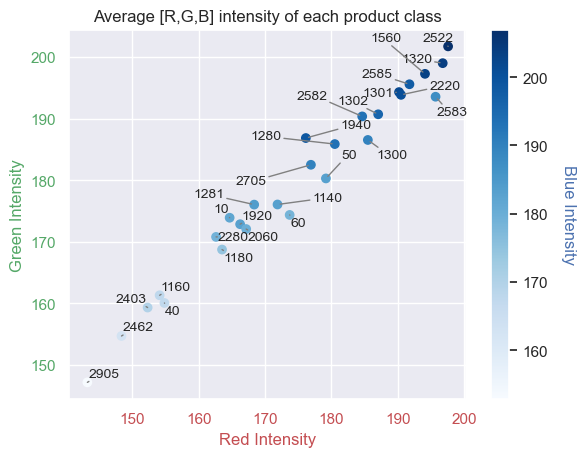

In [221]:
from adjustText import adjust_text

red_values = RGB_per_cat['meanR'].values
green_values = RGB_per_cat['meanG'].values
blue_values = RGB_per_cat['meanB'].values

# Scatter plot
plt.scatter(red_values, green_values, c=blue_values, cmap="Blues")
#plt.scatter(green_values, blue_values, c=red_values)
#plt.scatter(blue_values, red_values, c=green_values)

#Create a list of text annotations
image_names = RGB_per_cat.index
annotations = []
for i, name in enumerate(image_names):
    annotations.append(plt.text(red_values[i], green_values[i], name, fontsize=10))

# Adjust the text labels to avoid overlap
adjust_text(annotations, arrowprops=dict(arrowstyle='-', color='grey'), force_points=2.0, force_text=1.5)

plt.title('Average [R,G,B] intensity of each product class')
plt.xlabel('Red Intensity', color = 'r')
plt.ylabel('Green Intensity', color = 'g')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Blue Intensity', rotation=270, labelpad = 20, fontdict = {"size":12}, color = 'b')

plt.tick_params(axis='x', colors='r')
plt.tick_params(axis='y', colors='g')
plt.show();

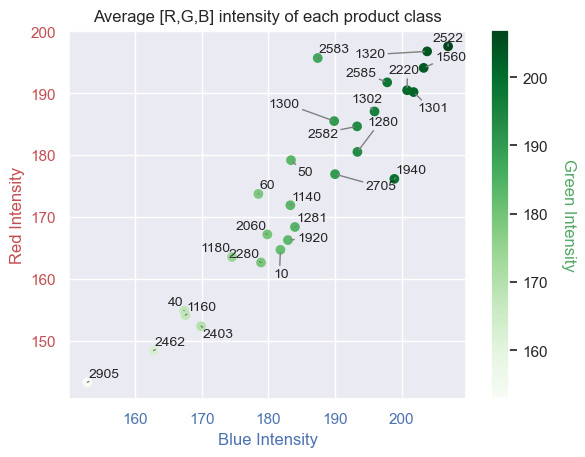

In [220]:
red_values = RGB_per_cat['meanR'].values
green_values = RGB_per_cat['meanG'].values
blue_values = RGB_per_cat['meanB'].values

# Scatter plot
plt.scatter(blue_values, red_values, c=blue_values, cmap="Greens")
# plt.scatter(green_values, blue_values, c=red_values)
# plt.scatter(blue_values, red_values, c=green_values)

#Create a list of text annotations
image_names = RGB_per_cat.index
annotations = []
for i, name in enumerate(image_names):
    annotations.append(plt.text(blue_values[i], red_values[i], name, fontsize=10))

# Adjust the text labels to avoid overlap
adjust_text(annotations, arrowprops=dict(arrowstyle='-', color='grey'), force_points=2.0, force_text=1.5)

plt.title('Average [R,G,B] intensity of each product class')
plt.xlabel('Blue Intensity', color = 'b')
plt.ylabel('Red Intensity', color = 'r')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Green Intensity', rotation=270, labelpad = 20, fontdict = {"size":12}, color = 'g')

plt.tick_params(axis='x', colors='b')
plt.tick_params(axis='y', colors='r')
plt.show();

Tryy adding to this plot all images from category 60 for example to see if they cluster around the mean value or not.

In [235]:
df_images_1cat = df_images[df_images['prdtypecode'] == 60]
df_images_1cat.head()

,prdtypecode,productid,imageid,meanR,meanG,meanB,px_0,px_1,px_2,px_3,...,px_29990,px_29991,px_29992,px_29993,px_29994,px_29995,px_29996,px_29997,px_29998,px_29999
40,60,4200874030,1316147329,223.5482,223.2656,224.9132,253,253,253,253,...,253,253,253,253,253,253,253,253,253,253
180,60,4200877294,1316199211,225.2547,225.6239,226.5528,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
270,60,4200875606,1316160872,166.4486,166.1129,162.2360,241,241,241,241,...,241,241,241,241,241,241,241,241,241,241
299,60,4200881171,1316258822,169.2614,165.6788,202.5758,252,255,255,252,...,255,255,255,255,255,255,255,255,255,255
375,60,4200871264,1316117316,151.9275,152.3080,157.0548,254,254,254,254,...,254,254,254,254,254,254,254,254,254,254


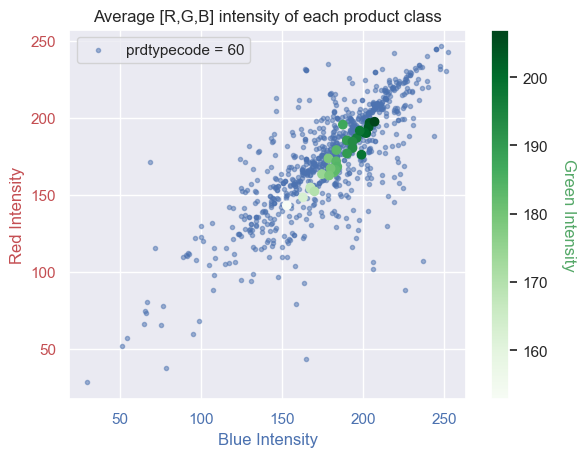

In [238]:
red_values = RGB_per_cat['meanR'].values
green_values = RGB_per_cat['meanG'].values
blue_values = RGB_per_cat['meanB'].values


# Scatter plot
plt.scatter(df_images_1cat.meanB, df_images_1cat.meanR, marker = '.', alpha = 0.5, label = "prdtypecode = 60")
plt.scatter(blue_values, red_values, c=blue_values, cmap="Greens")
# plt.scatter(green_values, blue_values, c=red_values)
# plt.scatter(blue_values, red_values, c=green_values)

#Create a list of text annotations
# image_names = RGB_per_cat.index
# annotations = []
# for i, name in enumerate(image_names):
#     annotations.append(plt.text(blue_values[i], red_values[i], name, fontsize=10))

# # Adjust the text labels to avoid overlap
# adjust_text(annotations, arrowprops=dict(arrowstyle='-', color='grey'), force_points=2.0, force_text=1.5)

plt.title('Average [R,G,B] intensity of each product class')
plt.xlabel('Blue Intensity', color = 'b')
plt.ylabel('Red Intensity', color = 'r')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Green Intensity', rotation=270, labelpad = 20, fontdict = {"size":12}, color = 'g')

plt.tick_params(axis='x', colors='b')
plt.tick_params(axis='y', colors='r')
plt.legend()
plt.show();

<ins>**ANOVA test**</ins>

In [123]:
# Import the library
import statsmodels.api

# hypothesis:
H0 = "There is No correlation between 'meanRGB' and 'prdtypecode'"
H1 = "There IS a correlation between 'meanRGB' and 'prdtypecode'"

## Realize the ANOVA test and display the results
## Try 'title_char_len', 'descr_char_len' or 'text_token_len'
result = statsmodels.formula.api.ols('meanB ~ prdtypecode', data=df_images).fit()
table = statsmodels.api.stats.anova_lm(result)

# get p-val an evaluate criteria
display(table)
p_val_anova = table.loc['prdtypecode','PR(>F)']

# evaluation
alpha = 0.05
def p_val_evaluation(p_val, alpha, H0, H1):
    if p_val >= alpha:
        print("H0 is not rejected \n H0:",H0)
    else:
        print("H0 is rejected, H1 is accepted \n H1:",H1)

print("ANOVA p-value = ", p_val_anova)
p_val_evaluation(p_val_anova,alpha, H0, H1)

,df,sum_sq,mean_sq,F,PR(>F)
prdtypecode,1.0,2.062858e+05,206285.812085,122.883632,1.546994e-28
Residual,84914.0,1.425459e+08,1678.708624,NaN,NaN


ANOVA p-value =  1.5469935243042498e-28
H0 is rejected, H1 is accepted 
 H1: There IS a correlation between 'meanRGB' and 'prdtypecode'


<ins>**Barplot**</ins>

In [179]:
RGB_per_cat.reset_index(inplace=True)
RGB_per_cat['prdtypecode'] = RGB_per_cat['prdtypecode'].astype(str)
display(RGB_per_cat.head())


,prdtypecode,meanR,meanG,meanB
0,10,164.672125,173.900505,181.811280
1,40,154.848153,160.053910,167.365718
2,50,179.171735,180.284372,183.397090
3,60,173.713197,174.356024,178.503859
4,1140,171.882739,176.053288,183.304761


In [185]:
display(RGB_per_cat.sort_values(by = 'meanB', ascending = True).head())

sorted_by_B = RGB_per_cat.sort_values(by = 'meanB', ascending = False)['prdtypecode'].to_list()
print(sorted_by_B)

,prdtypecode,meanR,meanG,meanB
26,2905,143.244161,147.161821,152.837240
20,2462,148.385787,154.693262,162.779558
1,40,154.848153,160.053910,167.365718
5,1160,154.127280,161.305093,167.557817
19,2403,152.321250,159.314675,169.907213


['2522', '1320', '1560', '1301', '2220', '1940', '2585', '1302', '1280', '2582', '2705', '1300', '2583', '1281', '50', '1140', '1920', '10', '2060', '2280', '60', '1180', '2403', '1160', '40', '2462', '2905']


Text(0.5, 1.0, 'Average R, G and B intensity per product category')

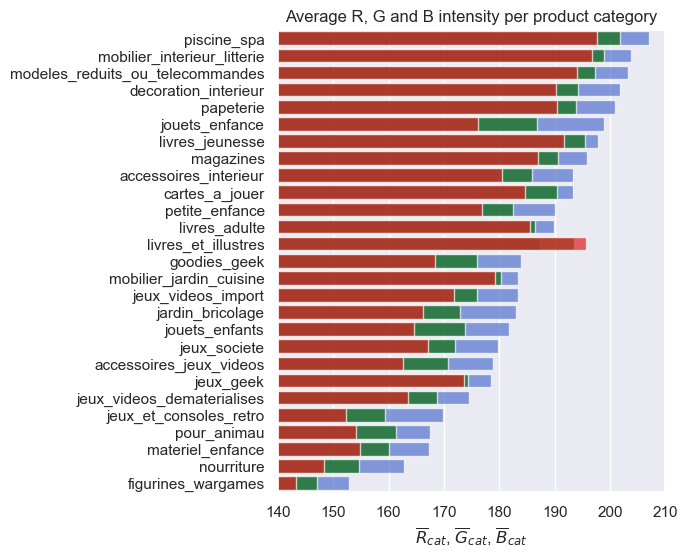

In [213]:
sns.set()

f, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,6))

class_codes = df['prdtypecode'].value_counts().index
class_labels = [ product_class.loc[product_class['prdtypecode']==code,'prodtype'].iloc[0] for code in class_codes]

sns.barplot(data=RGB_per_cat, y="prdtypecode", x="meanB", order = sorted_by_B, color = 'royalblue', alpha = 0.7)
sns.barplot(data=RGB_per_cat, y="prdtypecode", x="meanG", order = sorted_by_B, color = 'green', alpha = 0.7)
sns.barplot(data=RGB_per_cat, y="prdtypecode", x="meanR", order = sorted_by_B, color = 'red', alpha = 0.7)

ax.set_yticklabels(class_labels)
plt.ylabel('')
plt.xlabel('$\overline{R}_{cat}$, $\overline{G}_{cat}$, $\overline{B}_{cat}$')
plt.xlim([140,210])
plt.title("Average R, G and B intensity per product category")


## Prove that data is randomly gathered
Probe that there is no correlation between index of the observation and category.

In [239]:
df_images_indexed = df_images.reset_index()
df_images_indexed.head()

,index,prdtypecode,productid,imageid,meanR,meanG,meanB,px_0,px_1,px_2,...,px_29990,px_29991,px_29992,px_29993,px_29994,px_29995,px_29996,px_29997,px_29998,px_29999
0,0,10,3804725264,1263597046,205.4529,206.5443,234.1815,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,1,2280,436067568,1008141237,167.7998,172.5678,176.3561,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,2,50,201115110,938777978,251.9491,248.2853,244.1458,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,3,1280,50418756,457047496,76.9653,82.1617,111.9041,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,4,2705,278535884,1077757786,209.4138,198.2848,174.6685,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [240]:
# Import the library
import statsmodels.api

# hypothesis:
H0 = "There is No correlation between 'index' and 'prdtypecode'"
H1 = "There IS a correlation between 'index' and 'prdtypecode'"

## Realize the ANOVA test and display the results
## Try 'title_char_len', 'descr_char_len' or 'text_token_len'
result = statsmodels.formula.api.ols('index ~ prdtypecode', data=df_images_indexed).fit()
table = statsmodels.api.stats.anova_lm(result)

# get p-val an evaluate criteria
display(table)
p_val_anova = table.loc['prdtypecode','PR(>F)']

# evaluation
alpha = 0.05
def p_val_evaluation(p_val, alpha, H0, H1):
    if p_val >= alpha:
        print("H0 is not rejected \n H0:",H0)
    else:
        print("H0 is rejected, H1 is accepted \n H1:",H1)

print("ANOVA p-value = ", p_val_anova)
p_val_evaluation(p_val_anova,alpha, H0, H1)

,df,sum_sq,mean_sq,F,PR(>F)
prdtypecode,1.0,2.954091e+04,2.954091e+04,0.000049,0.994406
Residual,84914.0,5.102551e+13,6.009081e+08,NaN,NaN


ANOVA p-value =  0.9944057339979936
H0 is not rejected 
 H0: There is No correlation between 'index' and 'prdtypecode'


# Dump old non used functions below

### Image vectorization section

In [ ]:
# def find_left_boundary(image_array, threshold):
#     height, width, _ = image_array.shape

#     left_boundary = None
#     for col in range(width):
#         for row in range(height):
#             if any(image_array[row, col] < threshold):
#                 left_boundary = col
#                 #print("left_boundary = ", left_boundary)
#                 break
#         if left_boundary is not None:
#             break

#     if left_boundary is None:
#         left_boundary = 0

#     return left_boundary

# def find_right_boundary(image_array, threshold):
#     height, width, _ = image_array.shape

#     right_boundary = None
#     for col in range(width - 1, -1, -1):
#         for row in range(height):
#             if any(image_array[row, col] < threshold):
#                 right_boundary = col
#                 #print("right_boundary = ", right_boundary)
#                 break
#         if right_boundary is not None:
#             break

#     if right_boundary is None:
#         right_boundary = width - 1

#     return right_boundary

# def find_top_boundary(image_array, threshold):
#     height, width, _ = image_array.shape

#     top_boundary = None
#     for row in range(height):
#         for col in range(width):
#             if any(image_array[row, col] < threshold):
#                 top_boundary = row
#                 break
#         if top_boundary is not None:
#             break

#     if top_boundary is None:
#         top_boundary = 0

#     return top_boundary

# def find_bottom_boundary(image_array, threshold):
#     height, width, _ = image_array.shape

#     bottom_boundary = None
#     for row in range(height - 1, -1, -1):
#         for col in range(width):
#             if any(image_array[row, col] < threshold):
#                 bottom_boundary = row
#                 break
#         if bottom_boundary is not None:
#             break

#     if bottom_boundary is None:
#         bottom_boundary = height - 1

#     return bottom_boundary



# def crop_square(image_array, left_boundary, right_boundary, top_boundary, bottom_boundary):
#     cropped_width = right_boundary - left_boundary + 1
#     cropped_height = bottom_boundary - top_boundary + 1

#     # Calculate the side length of the largest square that fits within all boundaries
#     side_length = max(cropped_width, cropped_height)

#     left_pad = (side_length - cropped_width) // 2
#     right_pad = side_length - cropped_width - left_pad
#     top_pad = (side_length - cropped_height) // 2
#     bottom_pad = side_length - cropped_height - top_pad

#     left_boundary_new = max(0, left_boundary - left_pad)
#     right_boundary_new = min(image_array.shape[1] - 1, right_boundary + right_pad)
#     top_boundary_new = max(0, top_boundary - top_pad)
#     bottom_boundary_new = min(image_array.shape[0] - 1, bottom_boundary + bottom_pad)

#     cropped_image = image_array[top_boundary_new:bottom_boundary_new+1, left_boundary_new:right_boundary_new+1, :]
#     return cropped_image

In [ ]:
def resize_image(image, Nb_pixels):

#     array = np.array(image, dtype='uint8')
#     resized_image = cv2.resize(array, (Nb_pixels, Nb_pixels))     
    resized_image = cv2.resize(np.array(image, dtype='uint8'), (Nb_pixels, Nb_pixels))     
    
    return resized_image


# def image_vectorization(df, threshold, new_pixel_nb, verbose = True):
#     t0 = time.time()
    
#     vectors = []
    
#     for idx in range(df.shape[0]):
        
#         # construct the image file name
#         file = "./datasets/image_train/image_"+str(df.loc[idx,'imageid'])+"_product_"+str(df.loc[idx,'productid'])+".jpg"

#         image = cv2.imread(file)
        
#         # crop image 
#         cropped_image = crop_image(image, threshold = threshold)
        
#         # resize image (downscale)
#         resized_image = resize_image(cropped_image, Nb_pixels = new_pixel_nb)
    
#         # vectorize image (3D -> 1D)
#         Nx, Ny, Nch = resized_image.shape
#         vector_image = resized_image.reshape(Nx*Ny*Nch)        
        
#         vectors.append(vector_image)
        
#         if (idx % 5000)==0:
#             print("%d images at time %0.2f minutes" %(idx, ((time.time()-t0)/60) ) )

#     ## prepare dataframe with vector images
#     vector_dict = {'vector_img':vectors}
#     df_image_vectors = pd.DataFrame(vector_dict)
    
#     t1 = time.time()
#     if verbose:
# #        print("Vectorization of %d images takes %0.2f seconds" %(df.shape[0],(t1-t0)) )
#         print("Vectorization of %d images takes %0.2f hours" %(df.shape[0],((t1-t0)/3600)) )
                
    
#     return df_image_vectors





## using image_vectorization_v2 does this already!! 
def vector_to_column(df_vector, verbose = True):

    t0 = time.time()
    
    pixel_dict ={}

    ## to 2D array in order to easily take columns later
    matrix = []
    for vector in df_vector['vector_img']:    
        matrix.append(vector)
    
    matrix_arr = np.array(matrix)
    
    ## to dictionary, pixel by pixel
    for idx in range(matrix_arr.shape[1]):
        col_name = 'px_'+str(idx)
        pixel_dict[col_name] = matrix_arr[:,idx]
    
    ## to dataframe
    df_image_pixels = pd.DataFrame(pixel_dict)
    
    t1 = time.time()
    if verbose:
        print("vector to columns takes %0.2f seconds" %(t1-t0) )
        
    
    return df_image_pixels


df_image_pixels = vector_to_column(df_image_vectors, verbose=True)

### Computing mean RGB per image

In [35]:
# recalculate = False

# if recalculate:
#     t0 = time.time()

#     idx = 0

#     meanRGBs = []

#     # go thorugh all dataframe rows
#     for idx in range(df.shape[0]):#

#         # construct the image file name
#         file = "./datasets/image_train/image_"+str(df.loc[idx,'imageid'])+"_product_"+str(df.loc[idx,'productid'])+".jpg"

#         # load image
#         image = cv2.imread(file)

#         # get average RGB
#         avg_RGB_intensity = [ image[:,:,channel].mean() for channel in range(3) ]
        
# #         avg_RGB_intensity = []
# #         for channel in range(3):
# #             avg_RGB_intensity.append(image[:,:,channel].mean())

#         # list of all result for the whole image dataset, one image per row!
#         meanRGBs.append(avg_RGB_intensity)     


#     t1 = time.time()
#     print("Measuring Mean RGB for all images takes %0.2f minutes"%((t1-t0)/60) )

In [ ]:
# ## create new dataframe for image features
# df_image = df[['prdtypecode', 'productid', 'imageid']].copy()

# ## save truple mean RGB in dataframe
# df_image['meanRGB'] = meanRGBs

# print(df_image.shape)
# display(df_image.head())

In [ ]:
# ## cast to array, to extract the 3 columns as lists 
# meanRGB_array = np.array(meanRGBs)
# print(meanRGB_array.shape)

# ## Then save each channel into a new column on the Dataframe:
# df_image['meanR'] = list(meanRGB_array[:,0])
# df_image['meanG'] = list(meanRGB_array[:,1])
# df_image['meanB'] = list(meanRGB_array[:,2])

# df_image.head()

In [ ]:
# image.shape


### Representing the mean RGB per category
* These are different plots I tried

In [31]:
xx = RGB_per_cat['meanR'].values
yy = RGB_per_cat['meanG'].values
zz = RGB_per_cat['meanB'].values

from mpl_toolkits.mplot3d import Axes3D
#sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
ax.scatter(xx, yy, zz)

<Figure size 600x600 with 0 Axes>

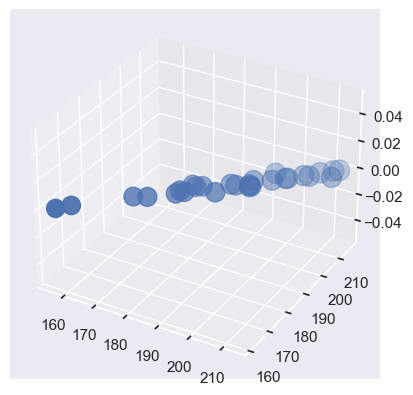

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(xx,yy,zz)

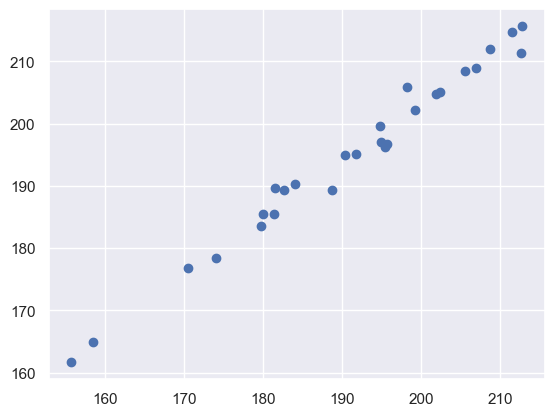

In [34]:
plt.scatter(xx,yy)
#plt.scatter(yy[i],zz[i])
#plt.scatter(xx[i],zz[i])

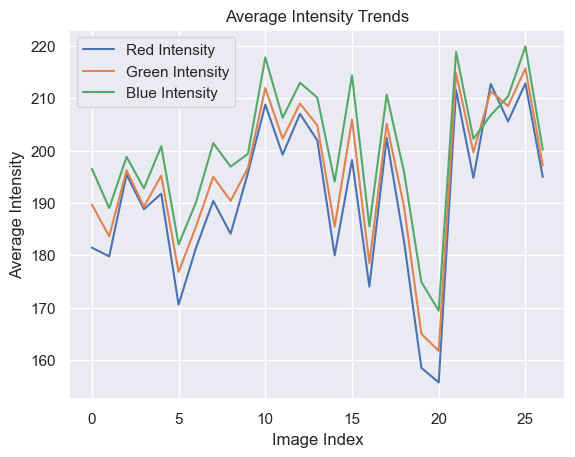

In [35]:
# Line plot
red_values = xx
green_values = yy
blue_values = zz

plt.plot(red_values, label='Red Intensity')
plt.plot(green_values, label='Green Intensity')
plt.plot(blue_values, label='Blue Intensity')
plt.xlabel('Image Index')
plt.ylabel('Average Intensity')
plt.legend()
plt.title('Average Intensity Trends')

# Display the plot
plt.show()